 # importar librerias

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
 
from tensorflow.keras.preprocessing import image

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, concatenate, MaxPooling2D, AveragePooling2D, Conv1D, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, Concatenate

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# generar dataset

## importar datos

In [2]:
meta_data = pd.read_excel('data_preliminar_trabajo_de_grado.Xlsx')
labels= meta_data['id_referencia'].unique()
labels_train = [str(x) for x in labels ]
train= ImageDataGenerator( zoom_range=0.2,horizontal_flip=True) \
.flow_from_directory(directory='data_tg/train',target_size=(512, 512), classes=labels_train, batch_size=1)

Found 500 images belonging to 125 classes.


In [3]:
# separamos variables de entrenamiento
x_train = []
y_train = []
labels_train = []

for i in range (0, len(train.labels)):
    x = np.squeeze(train[i][0])
    x_train.append(x)
    
    y = np.squeeze(train[i][1])
    y_train.append(y)
    
    labels = y.tolist()
    labels = labels.index(1)
    labels_train.append(labels)
    
x_train = np.array(x_train)
print(x_train.shape)
y_train = np.array(y_train)
print(y_train.shape)
labels_train = np.array(labels_train)
print(labels_train.shape)

(500, 512, 512, 3)
(500, 125)
(500,)


In [4]:
# función para graficar tripletas
def plot_triplet (triplet):
        plt.figure(figsize=(6, 2))
        for i in range (0, 3):
            plt.subplot(1, 3, i + 1  )
            plt.imshow(np.squeeze((triplet[i].astype('uint8'))))
            plt.xticks=([])
            plt.yticks([])
            plt.show()

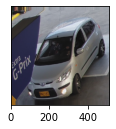

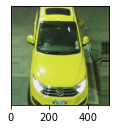

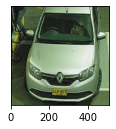

In [5]:
# muestra funcionamiento de función de graficación
plot_triplet([x_train[0], x_train[1], x_train[2]])

In [6]:
# creación de tripletas
def create_batch (batch_size=1, counter=0):
    anchors = np.zeros((batch_size, 512, 512, 3))
    positives = np.zeros((batch_size, 512, 512, 3))
    negatives = np.zeros((batch_size, 512, 512, 3))
    yy_train = np.zeros((batch_size, 125 ))
    
    for i in range(0, batch_size):
        #index = random.randint(0, len(train.labels) - 1)
        anc = x_train[counter]
        #print(anc.shape)
        yy = y_train[counter]
        #print(yy.shape)
        y = labels_train[counter]
        
        indices_for_pos = np.squeeze(np.where(labels_train == y))
        #print(indices_for_pos[0:5])
        indices_for_neg = np.squeeze(np.where(labels_train != y))
        
        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
    
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        yy_train[i] = yy
    
        
    return [anchors, positives, negatives, yy_train]

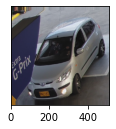

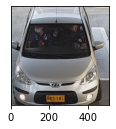

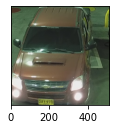

In [7]:
# muestra de tripleta
triplet = create_batch()[:3]
plot_triplet(triplet)

In [8]:
## función para generar dataser de entrenamiento
def data_generator (batch_size = 1, emb_dim=125):
    counter = 0
    while True:
        x = create_batch(batch_size, counter)[:3]
        y = create_batch(batch_size, counter)[-1]
        if counter < len(train.labels)-1 :
            counter = counter + 1
        else:
            counter = 0
        yield x, y

In [9]:
a = data_generator(1)


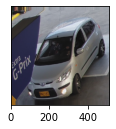

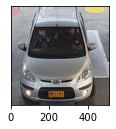

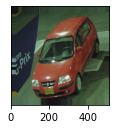

In [10]:
tripleta = next(a)[0]
plot_triplet(tripleta)

# Función de perdida

In [11]:
def triplet_loss (alpha=0.3, poolsize=125):
    def loss (y_true, y_pred):
        anc, pos, neg = y_pred[:, :poolsize], y_pred[:, poolsize:2*poolsize], y_pred[:, 2*poolsize:]
        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
        return tf.maximum(dp - dn + alpha, 0.)
    return loss

# Modelado

## rama complementaria red 1

In [12]:
final_dim=125 

in_anc = Input(shape=(512, 512, 3))
in_pos = Input(shape=(512, 512, 3))
in_neg = Input(shape=(512, 512, 3))
    
rn50 =  ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_anc)
        
# split the maxpooling layer
x = MaxPooling2D(pool_size= ( 4,16), strides= 4)(rn50)
x_1 = x[0:, :1, :,:]
x_2 = x[0:, 1:2, :, :]
x_3 = x[0:, 2:3, :, :]
x_4 = x[0:,3:, :,:]
        
# first skipconection
x_234 =  concatenate([x_2, x_3, x_4], axis=1)
x_234 = AveragePooling2D(pool_size=(3,1))(x_234)
x_234 = Conv2D(filters= 256, kernel_size= (1,1))(x_234)
#x_234 = self.bn(x_234)
#x_234 = self.acti(x_234)
cx_1 = Conv2D(filters= 256, kernel_size= (1,1))(x_1)
#cx_1 = self.bn(cx_1)
#cx_1 = self.acti(cx_1)
x_234 = concatenate([x_234, cx_1], axis=1)
x_234 = Conv2D(filters= 256, kernel_size= (1,1))(x_234)
x_234 = BatchNormalization()(x_234)
x_234 = Activation('relu')(x_234)
cx_1 = Add()([x_234, cx_1])
#cx_1 = self.acti(cx_1)
        
# second skipconection
x_134 =  concatenate([x_1, x_3, x_4], axis=1)
x_134 = AveragePooling2D(pool_size=(3,1))(x_134)
x_134 = Conv2D(filters= 256, kernel_size= (1,1))(x_134)
#x_134 = self.bn(x_134)
#x_134 = self.acti(x_134)
cx_2 = Conv2D(filters= 256, kernel_size= (1,1))(x_2)
#cx_2 = self.bn(cx_2)
#cx_2 = self.acti(cx_2)
x_134 = concatenate([x_134, cx_2], axis=1)
x_134 = Conv2D(filters= 256, kernel_size= (1,1))(x_134)
x_134 = BatchNormalization()(x_134)
x_134 = Activation('relu')(x_134)
cx_2 = Add()([x_134, cx_2])
#cx_2 = self.acti(cx_2)
        
# third skipconection
x_124 =  concatenate([x_1, x_2, x_4], axis=1)
x_124 = AveragePooling2D(pool_size=(3,1))(x_124)
x_124 = Conv2D(filters= 256, kernel_size= (1,1))(x_124)
#x_124 = self.bn(x_124)
#x_124 = self.acti(x_124)
cx_3 = Conv2D(filters= 256, kernel_size= (1,1))(x_3)
#cx_3 = self.bn(cx_3)
#cx_3 = self.acti(cx_3)
x_124 = concatenate([x_124, cx_3], axis=1)
x_124 = Conv2D(filters= 256, kernel_size= (1,1))(x_124)
x_124 = BatchNormalization()(x_124)
x_124 = Activation('relu')(x_124)
cx_3 = Add()([x_124, cx_3])
#cx_3 = self.acti(cx_3)
        
# fourth skipconection
x_123 =  concatenate([x_1, x_2, x_3], axis=1)
x_123 = AveragePooling2D(pool_size=(3,1))(x_123)
x_123 = Conv2D(filters= 256, kernel_size= (1,1))(x_123)
#x_123 = self.bn(x_123)
#x_123 = self.acti(x_123)
cx_4 = Conv2D(filters= 256, kernel_size= (1,1))(x_4)
#cx_4 = self.bn(cx_4)
#cx_4 = self.acti(cx_4)
x_123 = concatenate([x_123, cx_4], axis=1)
x_123 = Conv2D(filters= 256, kernel_size= (1,1))(x_123)
x_123 = BatchNormalization()(x_123)
x_123 = Activation('relu')(x_123)
cx_4 = Add()([x_123, cx_4])
#cx_4 = self.acti(cx_4)
        
##dense layer
conca = concatenate([cx_1, cx_2, cx_3, cx_4])
flatten = Flatten()(conca)
dense125 = Dense(units=final_dim, activation='softmax')(flatten)

net_cb1 = Model([in_anc, in_pos, in_neg], dense125)
net_cb1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 4, 1, 2048)   0           ['resnet50[0][0]']               
                                                                                              

 concatenate_3 (Concatenate)    (None, 2, 1, 256)    0           ['conv2d_3[0][0]',               
                                                                  'conv2d_4[0][0]']               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 2, 1, 256)    0           ['conv2d_6[0][0]',               
                                                                  'conv2d_7[0][0]']               
                                                                                                  
 concatenate_7 (Concatenate)    (None, 2, 1, 256)    0           ['conv2d_9[0][0]',               
                                                                  'conv2d_10[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)              (None, 2, 1, 256)    65792       ['concatenate_1[0][0]']          
          

In [13]:
batch_size = 1
epochs = 15
steps_per_epoch = int(len(train.labels)/batch_size)

net_cb1.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

net_cb1.fit(data_generator(batch_size, emb_dim=125), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=True)

Epoch 1/15
500/500 [==============================] - 804s 2s/step - loss: 16.7926 - accuracy: 0.0080
Epoch 2/15
500/500 [==============================] - 793s 2s/step - loss: 8.0865 - accuracy: 0.0120
Epoch 3/15
500/500 [==============================] - 790s 2s/step - loss: 6.7703 - accuracy: 0.0080
Epoch 4/15
500/500 [==============================] - 801s 2s/step - loss: 5.8968 - accuracy: 0.0220
Epoch 5/15
500/500 [==============================] - 792s 2s/step - loss: 5.2707 - accuracy: 0.0260
Epoch 6/15
500/500 [==============================] - 788s 2s/step - loss: 4.9938 - accuracy: 0.0320
Epoch 7/15
500/500 [==============================] - 787s 2s/step - loss: 4.4312 - accuracy: 0.0740
Epoch 8/15
500/500 [==============================] - 789s 2s/step - loss: 4.0868 - accuracy: 0.1020
Epoch 9/15
500/500 [==============================] - 794s 2s/step - loss: 3.8017 - accuracy: 0.1280
Epoch 10/15
500/500 [==============================] - 793s 2s/step - loss: 3.2942 - accur

## rama complementaria 2

### embeding model

In [16]:
# red pool_size 8X8
emb_dims = 125

in_emb =  Input(shape=(512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_emb)

mp = MaxPooling2D(pool_size= (8, 8), strides= 8)(rn50)
bn1 = BatchNormalization()(mp)

ap = AveragePooling2D(pool_size= (8, 8), strides= 8)(rn50)
bn2 = BatchNormalization()(ap)

suma = Add()([bn1, bn2])

bn3 = BatchNormalization()(suma)
acti = Activation('relu')(bn3)
conv1 = Conv2D(filters= 256, kernel_size= (1, 1))(acti)
bnconv = BatchNormalization()(conv1)

flat = Flatten()(bnconv)
dense125 = Dense(units=emb_dims, activation='softmax')(flat)

embeding_model_cb2 = Model(in_emb, dense125)

embeding_model_cb2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 2, 2, 2048)  0           ['resnet50[0][0]']               
                                                                                            

### siamese net

In [17]:
# red siames pool_size8X8
in_anc = Input(shape=(512, 512, 3))
in_pos = Input(shape=(512, 512, 3))
in_neg = Input(shape=(512, 512, 3))

emb_anc = embeding_model_cb2(in_anc)
emb_pos = embeding_model_cb2(in_pos)
emb_neg = embeding_model_cb2(in_neg)

emb_conca = concatenate([emb_anc, emb_pos, emb_neg], axis=1)

net_cb2 =  Model ([in_anc, in_pos, in_neg], [emb_conca, emb_anc])

net_cb2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_13 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                          

In [18]:
batch_size = 1
epochs = 15
steps_per_epoch = int(len(train.labels)/batch_size)

net_cb2.compile(loss= [triplet_loss(alpha=0.3, poolsize=125),'categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

net_cb2.fit(data_generator(batch_size, emb_dim=125), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=True)

Epoch 1/15
500/500 [==============================] - 2190s 4s/step - loss: 7.5582 - concatenate_9_loss: 0.2991 - model_2_loss: 7.2590 - concatenate_9_accuracy: 0.0080 - model_2_accuracy: 0.0160
Epoch 2/15
500/500 [==============================] - 2145s 4s/step - loss: 7.2193 - concatenate_9_loss: 0.2991 - model_2_loss: 6.9202 - concatenate_9_accuracy: 0.0020 - model_2_accuracy: 0.0100
Epoch 3/15
500/500 [==============================] - 2140s 4s/step - loss: 6.7506 - concatenate_9_loss: 0.2994 - model_2_loss: 6.4511 - concatenate_9_accuracy: 0.0020 - model_2_accuracy: 0.0060
Epoch 4/15
500/500 [==============================] - 2135s 4s/step - loss: 6.4068 - concatenate_9_loss: 0.2994 - model_2_loss: 6.1074 - concatenate_9_accuracy: 0.0040 - model_2_accuracy: 0.0100
Epoch 5/15
500/500 [==============================] - 2126s 4s/step - loss: 5.7954 - concatenate_9_loss: 0.2994 - model_2_loss: 5.4960 - concatenate_9_accuracy: 0.0060 - model_2_accuracy: 0.0180
Epoch 6/15
500/500 [=====

## rama global

In [14]:
final_dim = 125

in_anc = Input(shape= (512, 512, 3))
in_pos = Input(shape= (512, 512, 3))
in_neg = Input(shape= (512, 512, 3))

rn50 = ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_anc)

ap = AveragePooling2D(pool_size= (8, 8), strides= 8)(rn50)
bn = BatchNormalization()(ap)
acti = Activation('relu')(bn)
conv1 = Conv2D(filters= 256, kernel_size= (1,1))(acti)
        
flatten = Flatten()(conv1)
dense125 = Dense(units= final_dim, activation='softmax')(flatten)

net_g = Model([in_anc, in_pos, in_neg], dense125)

net_g.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d_4 (AveragePo  (None, 2, 2, 2048)  0           ['resnet50[0][0]']               
 oling2D)                                                                                   

In [15]:
batch_size = 1
epochs = 15
steps_per_epoch = int(len(train.labels)/batch_size)

net_g.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

net_g.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
500/500 [==============================] - 797s 2s/step - loss: 11.2667 - accuracy: 0.0180
Epoch 2/15
500/500 [==============================] - 779s 2s/step - loss: 6.3377 - accuracy: 0.0300
Epoch 3/15
500/500 [==============================] - 783s 2s/step - loss: 4.9337 - accuracy: 0.0260
Epoch 4/15
500/500 [==============================] - 786s 2s/step - loss: 4.0489 - accuracy: 0.0860
Epoch 5/15
500/500 [==============================] - 777s 2s/step - loss: 3.2483 - accuracy: 0.2000
Epoch 6/15
500/500 [==============================] - 785s 2s/step - loss: 2.6875 - accuracy: 0.2880
Epoch 7/15
500/500 [==============================] - 789s 2s/step - loss: 2.3075 - accuracy: 0.4060
Epoch 8/15
500/500 [==============================] - 816s 2s/step - loss: 2.0147 - accuracy: 0.4720
Epoch 9/15
500/500 [==============================] - 806s 2s/step - loss: 1.7968 - accuracy: 0.5100
Epoch 10/15
500/500 [==============================] - 793s 2s/step - loss: 1.5870 - accur